In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import tensorflow.contrib.layers as ly
%matplotlib inline  

In [2]:
batch_size = 64
z_dim = 128
s = 32
s2, s4, s8, s16 =\
    int(s / 2), int(s / 4), int(s / 8), int(s / 16)
is_svhn = True
channel = 3 if is_svhn is True else 1
ckpt_dir = './ckpt_wgan_svhn'

In [3]:
def generate_from_ckpt():
    with tf.device('/gpu:2'):
        z, train = get_generator()
    config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.6
    if ckpt_dir != None:
        with tf.Session(config=config) as sess:
            saver = tf.train.Saver()
            saver.restore(sess, tf.train.latest_checkpoint(ckpt_dir))
            batch_z = np.random.normal(0, 1.0, [batch_size, z_dim]) \
                .astype(np.float32)
            rs = train.eval(feed_dict={z:batch_z})
#     print(rs[0].shape)
    overall = []
    for i in range(8):
        temp = []
        for j in range(8):
            temp.append(rs[i * 8 + j])

        overall.append(np.concatenate(temp, axis=1))
    res = np.concatenate(overall, axis=0)
#     res = cv2.cvtColor((res)*255, cv2.COLOR_GRAY2BGR)
#     cv2.imwrite('sample.png', res)
    res = np.squeeze(res)
    res = (res+1)/2
    plt.figure(figsize=[8, 8])
    plt.imshow(res)
    plt.show()

In [4]:
def get_generator():
    z = tf.placeholder(dtype=tf.float32, shape=[batch_size, z_dim])
    with tf.variable_scope('generator'):
        train = generator(z)
    theta_g = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

    return z, train

In [5]:
def lrelu(x, leak=0.3, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [6]:
def generator(z):
    train = ly.fully_connected(
        z, 4 * 4 * 512, activation_fn=lrelu, normalizer_fn=ly.batch_norm)
    train = tf.reshape(train, (-1, 4, 4, 512))
    train = ly.conv2d_transpose(train, 256, 3, stride=2,
                                activation_fn=tf.nn.relu, normalizer_fn=ly.batch_norm, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, 128, 3, stride=2,
                                activation_fn=tf.nn.relu, normalizer_fn=ly.batch_norm, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, 64, 3, stride=2,
                                activation_fn=tf.nn.relu, normalizer_fn=ly.batch_norm, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, channel, 3, stride=1,
                                activation_fn=tf.nn.tanh, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    return train

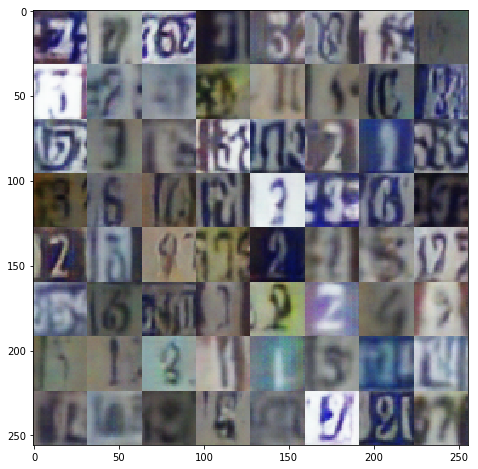

In [7]:
generate_from_ckpt()